In [1]:
import pandas as pd
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.decomposition import TruncatedSVD


In [2]:
df = pd.read_csv("./golestan.csv")

print(df.shape)
print(df.columns)


(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [3]:
df.head()

,hekayt,bab
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,1
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,1
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,1
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,1
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,1


In [4]:
df = df.dropna(subset=["hekayt"])
df = df.dropna(subset=["bab"])

print(df.shape)
print(df.columns)

(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [5]:
df["bab"].value_counts()

bab
8    109
2     48
1     41
3     28
5     21
7     20
4     14
6      9
Name: count, dtype: int64

In [6]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

In [7]:
base_stopwords = set(stopwords_list())

In [8]:
extra_stopwords = {
    "است", "هست", "بود", "شد", "باشد",
    "می", "هم", "را", "که", "با", "از", "برای",
    "ای", "این", "آن", "من", "تو", "ما", "شما", "او",
}

additional_stopwords = set()

for i in extra_stopwords:
    print(f'if {i} is in stopwords list? {i in base_stopwords}')
    if i not in base_stopwords: 
        additional_stopwords.add(i)

additional_stopwords

if شما is in stopwords list? True
if تو is in stopwords list? True
if بود is in stopwords list? True
if می is in stopwords list? True
if برای is in stopwords list? True
if شد is in stopwords list? True
if او is in stopwords list? True
if با is in stopwords list? True
if من is in stopwords list? True
if ما is in stopwords list? True
if هم is in stopwords list? True
if باشد is in stopwords list? True
if این is in stopwords list? True
if هست is in stopwords list? False
if از is in stopwords list? True
if است is in stopwords list? True
if آن is in stopwords list? True
if ای is in stopwords list? False
if که is in stopwords list? True
if را is in stopwords list? True


{'ای', 'هست'}

In [9]:
stopwords = base_stopwords.union(additional_stopwords)

print(len(base_stopwords))
print(len(stopwords))

389
391


In [10]:
def preprocess_hekayat(text):
    text = str(text)

    text = normalizer.normalize(text)

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if re.search(r"[آ-یءئ]", t)]
    tokens = [t for t in tokens if t not in stopwords]

    tokens_stemmed = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens_stemmed)


In [11]:
df["clean_hekayt"] = df["hekayt"].apply(preprocess_hekayat)

In [12]:
df.to_csv("golestan_clean.csv", index=False)
df[["hekayt", "clean_hekayt"]].head()

,hekayt,clean_hekayt
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,پادشاه شنید کشتن اسیر اشار بیچاره حال نومید مل...
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,ملوک خراس محمود سبکتگین خواب چن دید جمله ریخته...
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,ملک‌زاده شنید کوتاه حقیر برادر بلند خوب‌رو بار...
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,طایفه دزد عرب سر کوه نشسته_بودند منفذ کارو بست...
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,سرهنگ‌زاده سرا اغلم دید عقل کیاست فه فراست زای...


In [13]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True  
)

x_tfidf = tfidf_vectorizer.fit_transform(df["clean_hekayt"])

svd = TruncatedSVD(n_components=100, random_state=42)
x_tfidf = svd.fit_transform(x_tfidf)



In [14]:

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names[:30]

array(['آب', 'آبرو', 'آبگینه', 'آت', 'آتش', 'آثار', 'آجل', 'آحاد', 'آخر',
       'آد', 'آداب', 'آدم', 'آدمی', 'آدمیس', 'آدینه', 'آذارند', 'آر',
       'آرا', 'آراسته', 'آرد', 'آرند', 'آزاد', 'آزادگ', 'آزار', 'آزر',
       'آزرده', 'آزموده', 'آس', 'آسا', 'آسان'], dtype=object)

In [15]:
def fit_kmeans(X, k):

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42
    )

    kmeans.fit(X)
    labels = kmeans.labels_

    # print(kmeans.cluster_centers_)  

    return kmeans, labels


In [16]:
from sklearn.manifold import TSNE
import scipy.sparse as sp

# Convert sparse→dense if needed
if sp.issparse(x_tfidf):
    X_input = x_tfidf.toarray()
else:
    X_input = x_tfidf

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_2d = tsne.fit_transform(X_input)

def plot_tsne_clusters(X_2d, labels, k):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=labels,
        cmap='tab10',
        s=30,
        alpha=0.9
    )
    plt.title(f"t-SNE Visualization for k={k}", fontsize=14)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(False)
    plt.show()



In [17]:
k = 5
kmeans_final, labels_final = fit_kmeans(x_tfidf, k)

# cluster sizes
unique, counts = np.unique(labels_final, return_counts=True)
for lbl, cnt in zip(unique, counts):
    print(f"Cluster {lbl}: {cnt} hekayat")

threshold = 0.15 * np.mean(counts)
print("Are clusters balanced?", np.std(counts) < threshold)

# cluster–bab relationship
df_clusters = pd.DataFrame({
    "cluster": labels_final,
    "bab": df["bab"]
})
cluster_groups = df_clusters.groupby("cluster")["bab"].value_counts()
print(cluster_groups)

nmi = normalized_mutual_info_score(df["bab"], labels_final)
print("NMI:", nmi)



Cluster 0: 23 hekayat
Cluster 1: 24 hekayat
Cluster 2: 34 hekayat
Cluster 3: 82 hekayat
Cluster 4: 127 hekayat
Are clusters balanced? False
cluster  bab
0        8      15
         2       3
         4       2
         1       1
         3       1
         5       1
1        8      15
         5       3
         1       2
         3       2
         2       1
         6       1
2        1      13
         8      10
         2       7
         3       2
         7       2
3        1      19
         2      19
         8      13
         3      12
         7       7
         5       6
         6       4
         4       2
4        8      56
         2      18
         3      11
         5      11
         7      11
         4      10
         1       6
         6       4
Name: count, dtype: int64
NMI: 0.09370639508748474


In [18]:
kmeans_model, labels = fit_kmeans(x_tfidf, k)

centers = kmeans_model.cluster_centers_
print("Cluster centers shape:", centers.shape)


Cluster centers shape: (5, 100)


In [19]:
def show_cluster_top_terms(kmeans_model, vectorizer, top_n=10):
    centers = kmeans_model.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()

    for idx, center in enumerate(centers):
        print(f"\nCluster {idx} top terms:")
        top_indices = center.argsort()[::-1][:top_n]
        for i in top_indices:
            print(f"  {feature_names[i]}  ({center[i]:.3f})")


In [20]:
show_cluster_top_terms(kmeans_model, tfidf_vectorizer, top_n=10)



Cluster 0 top terms:
  آبرو  (0.179)
  آب  (0.167)
  آد  (0.044)
  آراسته  (0.036)
  آدم  (0.036)
  آفرین  (0.032)
  آتش  (0.031)
  آستین  (0.030)
  آثار  (0.030)
  آمیز  (0.028)

Cluster 1 top terms:
  آب  (0.136)
  آثار  (0.049)
  آدمی  (0.043)
  آشوب  (0.040)
  آسا  (0.040)
  آویختند  (0.039)
  آغو  (0.037)
  آداب  (0.036)
  آس  (0.035)
  آفتاب  (0.034)

Cluster 2 top terms:
  آب  (0.196)
  آت  (0.097)
  آتش  (0.044)
  آورد  (0.035)
  آنگاه  (0.031)
  آمدن  (0.031)
  آزموده  (0.027)
  آرند  (0.025)
  آر  (0.022)
  آگه  (0.022)

Cluster 3 top terms:
  آب  (0.202)
  آدم  (0.027)
  آجل  (0.021)
  آتش  (0.021)
  آدینه  (0.021)
  آفتاب  (0.017)
  آذارند  (0.016)
  آرد  (0.015)
  آراسته  (0.015)
  آزار  (0.015)

Cluster 4 top terms:
  آب  (0.150)
  آبگینه  (0.030)
  آحاد  (0.016)
  آمده  (0.014)
  آموزند  (0.012)
  آرا  (0.009)
  آدمی  (0.008)
  آمدند  (0.008)
  آمد  (0.008)
  آمده_بودند  (0.008)


In [21]:
# for k in range(1, 20):
#     kmeans_model, cluster_labels = fit_kmeans(x_tfidf, k)
#     plot_clusters_tsne(x_tfidf, cluster_labels)

In [22]:
# for k in range(4, 8):
#     print(f"K={k}")
#     kmeans, labels = fit_kmeans(x_tfidf, k)
#     plot_tsne_clusters(x_tfidf, labels)


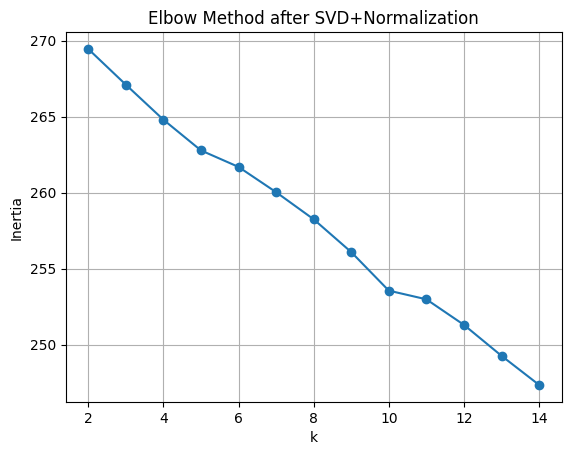

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Step 1: Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(x_tfidf)

# Step 2: Normalize for cosine-like KMeans
normalizer = Normalizer()
X_final = normalizer.fit_transform(X_reduced)


# Step 3: Elbow method
inertias = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)
    inertias.append(km.inertia_)


plt.plot(range(2, 15), inertias, marker='o')
plt.title("Elbow Method after SVD+Normalization")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [24]:
kmeans, labels = fit_kmeans(X_final, 10)
plot_clusters_tsne(X_final, labels)


NameError: name 'plot_clusters_tsne' is not defined